
The provided code employs a Monte Carlo simulation to model traffic flow within a network of towers. The Monte Carlo method is a powerful computational technique widely used in various fields, including finance, engineering, and physics, to model complex systems and processes that involve a high degree of uncertainty.

**Monte Carlo Simulation in Traffic Modeling:**
In this specific application, Monte Carlo simulation is utilized to replicate the dynamic and stochastic nature of traffic flow in a network of communication towers. This approach allows for the generation of multiple simulations, each representing a possible scenario based on random events and varying conditions.

**Key Elements of the Simulation:**
The simulation integrates several stochastic processes to emulate real-world traffic behavior. It leverages a Geometric Brownian Motion (GBM) to model the growth and fluctuations of traffic intensity, considering factors like drift and volatility. Additionally, daily variations, rare events, and the possibility of system crashes are incorporated to reflect the unpredictability of traffic patterns.

**Incorporating Population Density and Capacity:**
The simulation considers the influence of population density on the initial capacity of each tower. By randomly assigning population density values to the towers, the model introduces spatial variability in the network, a crucial factor in traffic dynamics.

**Visualizing Traffic Flows:**
The resulting traffic flows between towers are visualized using a network graph representation. This provides a clear visual depiction of the interconnections and traffic intensities between different towers in the simulated network.


# Code walkthrough:

# Initialization:

* num_towers and num_simulations define the number of towers and simulation runs, respectively.
* population_density is randomly generated to represent the density of people around each tower.
* initial_capacity is calculated based on a random capacity range and the population density.

# GBM Parameters:

mu and sigma are derived from the ratios of capacity relative to the first tower, introducing drift and volatility for the Geometric Brownian Motion (GBM).
T, dt, and N specify the time horizon, time step, and number of steps for the simulation.

# Traffic Initialization:

t is an array representing time steps within the time horizon.
W generates a 3D array of standard normal random numbers, cumulatively summed to create Brownian motion.

# GBM Simulation Loop:

* For each tower and simulation run, the code simulates traffic using a GBM process.
* X represents the GBM process, which includes drift and volatility components based on the tower's parameters.
* Periodic variation is introduced using a sine function, and rare random events are simulated using a normal distribution.
* A Poisson process is added to modulate traffic intensity, ensuring traffic does not decay over time.
Crash Handling:

* A small probability of crashes is introduced (crash_prob) or crashes are triggered when traffic exceeds capacity.
* If a crash occurs, the traffic is set to zero for a random duration within a specified range to simulate down time.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


#simulation parameters
num_towers = 5
num_simulations = 10
population_density = [np.random.randint(1,20) for i in range(num_towers)]   # Corresponding population density values
initial_capacity = []
for i in range(num_towers):
    initial_capacity.append(np.random.randint(1500, 2000) * population_density[i])

# GBM parameters
# Calculate the ratios
ratios = [cap / initial_capacity[0] for cap in initial_capacity]
mu = 0.01 * ratios[0]
sigma = 0.5 * ratios[0]
T = 100  # Time horizon
dt = 1  # Time step
N = int(T / dt)  # Number of steps
lambda_poisson = np.sqrt(np.mean(initial_capacity))
# Initialize variables
t = np.linspace(0, T, N+1)
W = np.random.standard_normal(size=(num_towers, num_simulations, N+1))
W = np.cumsum(W, axis=2) * np.sqrt(dt)  # Brownian motion
initial_traffic = np.array([np.random.randint(1000) for i in range(num_towers)])  # Initial traffic for each tower
traffic = np.zeros((num_towers, num_simulations, N+1))
# Simulate traffic for each tower using GBM
for i in range(num_towers):
    for j in range(num_simulations):
        X = (mu - 0.5 * sigma**2) * t + sigma * W[i, j]  # GBM process
        traffic[i, j] = initial_traffic[i] * np.exp(X)
        daily_variation = np.sin(2 * np.pi * t / 5)  # Assumes a 5-t cycle
        traffic[i, j] *= (1 + 0.1 * daily_variation)  # Adjust traffic based on daily variation
        traffic[i, j] *= np.random.normal(1, 0.1, N+1) # simulate random rare events
        # add a poisson process to ensure traffic does not decay
        poisson_events = np.random.poisson(lambda_poisson, N+1)
        traffic[i, j] += poisson_events[:N+1]
        # Check for crashes with very small probability (0.01) or when traffic > capacity
        crash_prob = 0.01
        crash_time = np.argmax(np.random.rand(N+1) < crash_prob)
        crash_time_cap =  np.argmax(traffic[i, j] > initial_capacity[i])
        if crash_time > 0:
            traffic[i, j, crash_time:crash_time+np.random.randint(120)] = 0

# Create a graph representation of the network (complete graph)
G = nx.complete_graph(num_towers)
traffic_flows = np.zeros((num_towers, num_towers, num_simulations, N+1))
for i, j in G.edges():
    for k in range(num_simulations):
        traffic_flows[i, j, k] = traffic[i, k]  # Traffic flows from tower i to tower j




## Below is a graph representation of the netowrk flow , high traffic areas are highlighted with denser edges

<ipython-input-60-dedfa0aea80f>:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


Text(0.5, 1.0, 'Network of Towers')

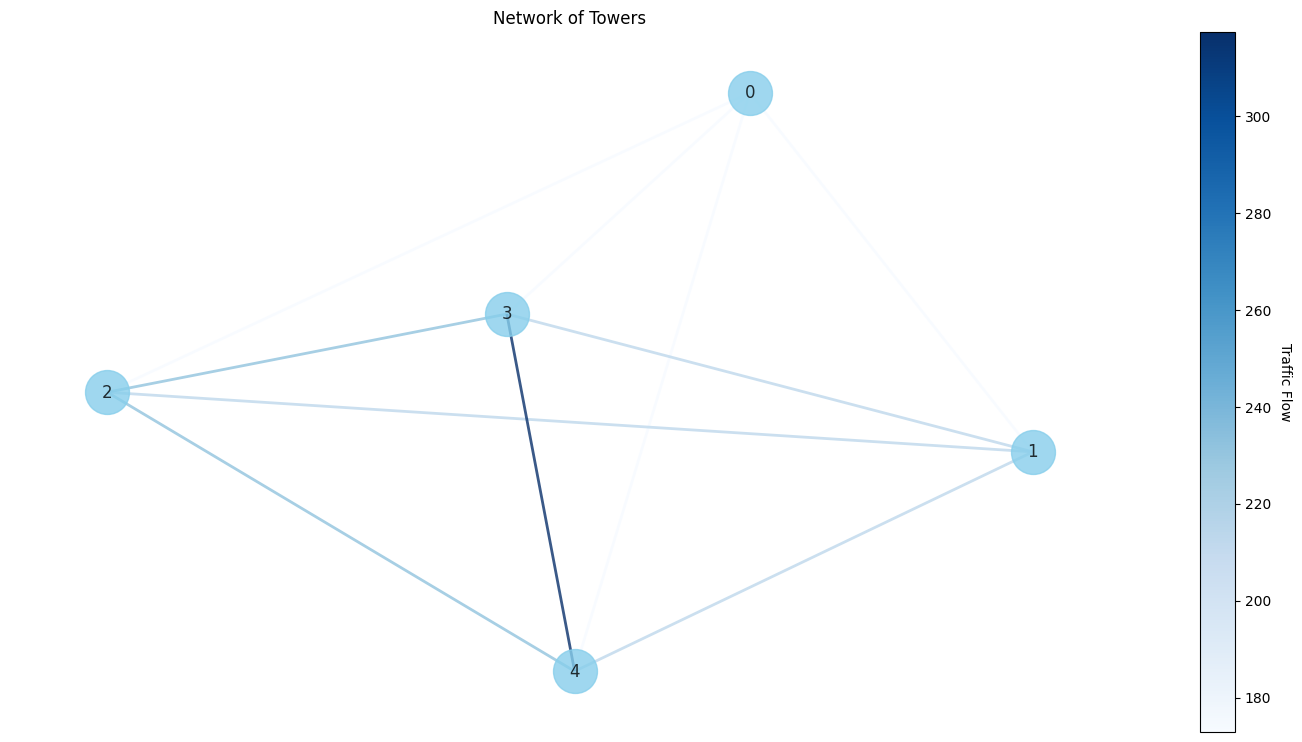

In [60]:
# Plot the network graph
plt.figure(figsize=(14, 7))
pos = nx.spring_layout(G)
edge_weights = [np.mean(traffic_flows[i, j]) for i, j in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue',
        width=2, edge_color=edge_weights, edge_cmap=plt.cm.Blues, alpha=0.8)
edge_norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=edge_norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Traffic Flow', rotation=270, labelpad=15)

plt.title('Network of Towers')


## For each tower we can plot the simulated time series of network traffic going through it

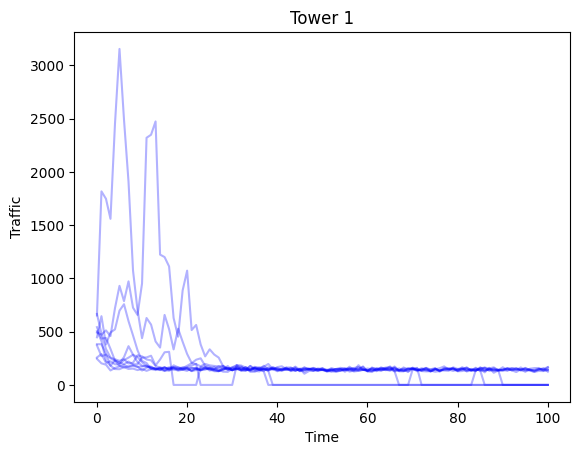

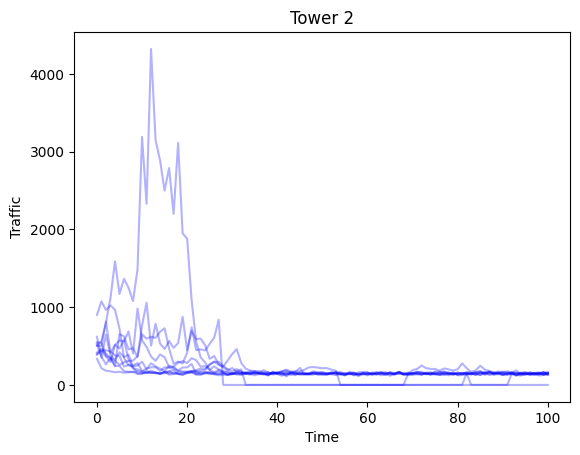

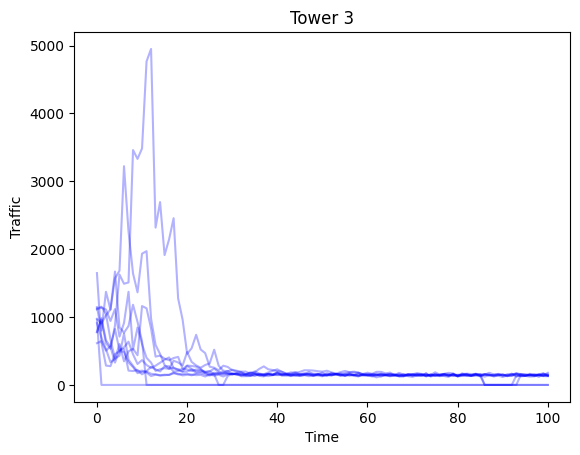

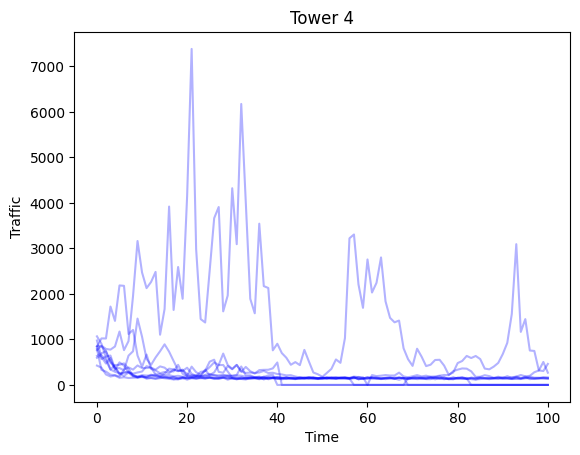

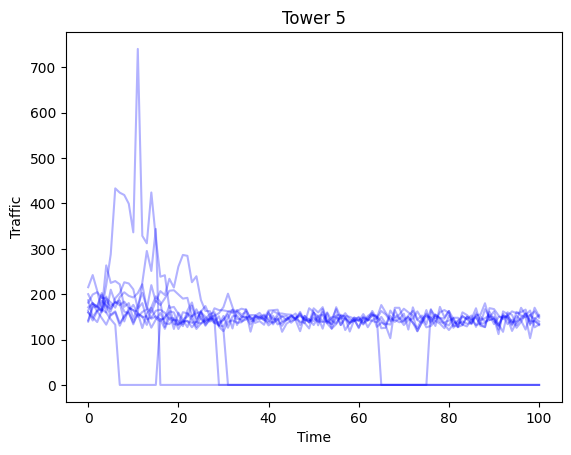

In [61]:
# Plot time series for each tower

for i in range(num_towers):
    for j in range(num_simulations):
        plt.plot(t, traffic[i, j], alpha=0.3, color='blue')  # Plot all simulations with low opacity
    #plt.plot(t, np.mean(traffic[i], axis=0), color='red', linewidth=2)  # Plot the average traffic
    plt.xlabel('Time')
    plt.ylabel('Traffic')
    plt.title(f'Tower {i+1}')
    plt.show()


## Finally we plot the averaged values for each tower based on the Monte carlo simulation

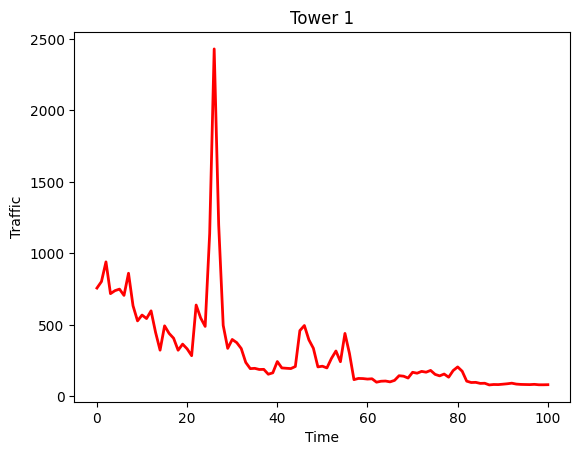

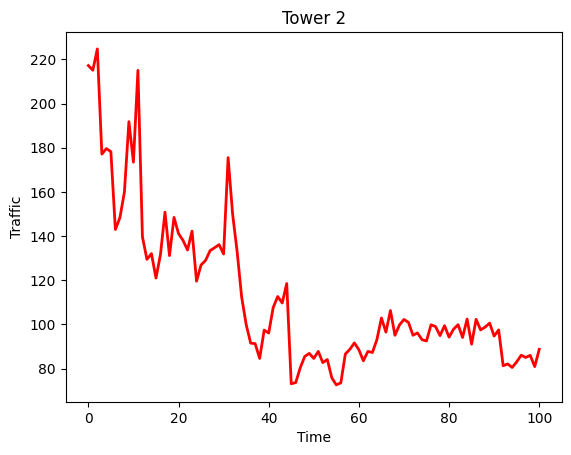

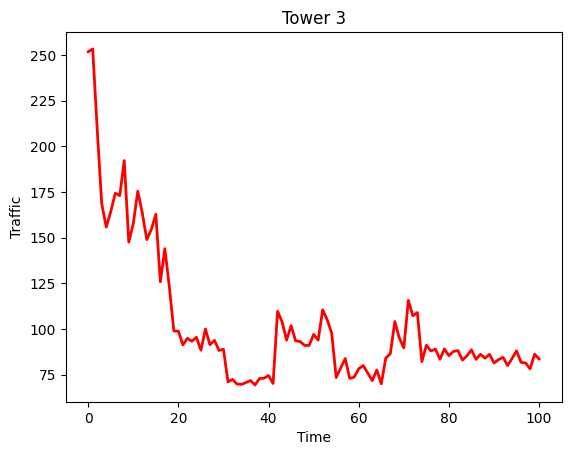

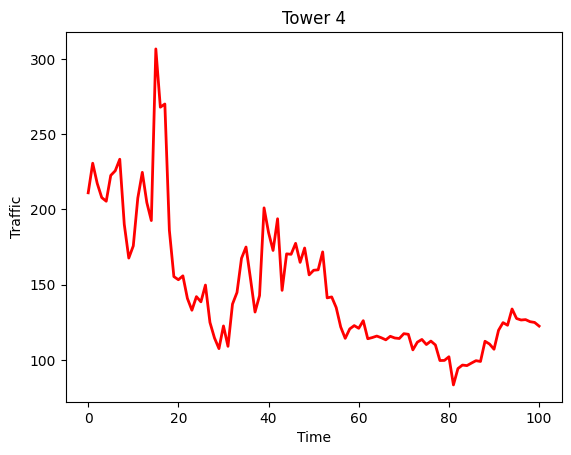

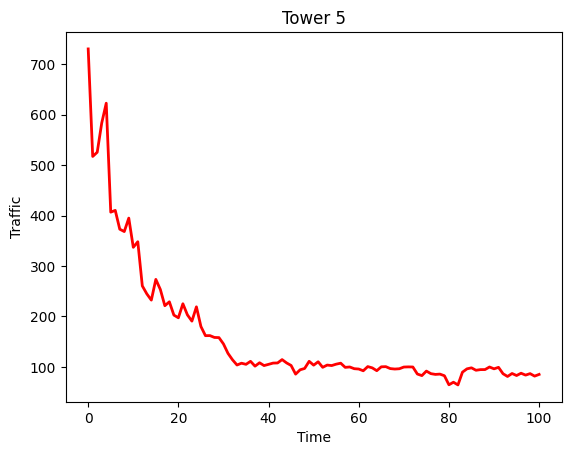

In [58]:
for i in range(num_towers):
  plt.plot(t, np.mean(traffic[i], axis=0), color='red', linewidth=2)  # Plot the average traffic
  plt.xlabel('Time')
  plt.ylabel('Traffic')
  plt.title(f'Tower {i+1}')
  plt.show()